## Split Audio

In [1]:
from pydub import AudioSegment
import os
import pandas as pd
import numpy as np
import librosa
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
inputDirectory = '../input/all/'

In [3]:
sr=22000

In [4]:
def split_and_read(filename, audioFile, metaDataFile, sample_rate=sr):
    """
    Read .wav file, split all vocalizations, and resample to a fixed sample rate for uniformity
    Params - 
    filename: name of wav file
    audioPath: path to wav file
    metaDataPath: path to txt file containing the start and end times for each vocalization
    
    Returns - 
    List containg arrays corresponding to each vocalization in wav file of format:(resampled data of one vocalization in in wav file of size (length of vocalization in seconds*sample rate), length of vocalization in seconds, if the vocalization contains coarse crackles, if the vocalization contains fine crackles)
    """
    print('working on audio: ' + audioFile + ' and metafile: ' + metaDataFile)
    recording_annotations = pd.read_csv(metaDataFile,
                                        names=['Start', 'End', 'bit1', 'bit2'], delimiter='\t')

    recording_audio = AudioSegment.from_wav(audioFile)
    data = [filename]
    print(len(recording_annotations.index))

    for i in range(len(recording_annotations.index)):
        
        row = recording_annotations.loc[i]
        start = row['Start']
        end = row['End']
        bit1 = int(row['bit1'])
        bit2 = int(row['bit2'])
        
        audio_chunk = recording_audio[int(start*1000) : int(end*1000)]
        
        if ((bit1 == 1) & (bit2 == 0)):
            if_bit1 = True
            if_bit2 = False
        elif (bit1 == 0) & (bit2 == 1):
            if_bit1 = False
            if_bit2 = True
        elif (bit1 == 0) & (bit2 == 0):
            if_bit1 = False
            if_bit2 = False
        elif (bit1 == 1) & (bit2 == 1):
            if_bit1 = True
            if_bit2 = True
            
        if ((if_bit1 == True) and (if_bit2 == False)):
            samples = audio_chunk.get_array_of_samples()
            audio_chunk_data = np.array(samples).astype(np.float32)/32768 # convert 24 bit wav file to 16 bit
            audio_chunk_resampled = librosa.resample(audio_chunk_data, audio_chunk.frame_rate, sample_rate, res_type='kaiser_best')
        
            data.append([audio_chunk_resampled, len(audio_chunk), if_bit1, if_bit2])
        
            print ("length of audio: " ,len(audio_chunk))
        
    return data

In [5]:
rumble = []
voc_lengths = []
for filename in os.listdir(inputDirectory):
    if filename.endswith(".wav"):
        audioFile = os.path.join(inputDirectory, filename)
        metaDataFile = os.path.join(inputDirectory, filename.replace(".wav",".txt"))
        data = split_and_read(filename, audioFile, metaDataFile)
        voc_chunk_data = [(d[0], d[2], d[3]) for d in data[1:]]
        rumble.extend(voc_chunk_data)
        voc_lengths.extend((d[1]) for d in data[1:])

working on audio: ../input/all/Kaziranga Wild Ele Call 25_18.01.2020.wav and metafile: ../input/all/Kaziranga Wild Ele Call 25_18.01.2020.txt
1
working on audio: ../input/all/Kaziranga Wild Ele Call 73_28.01.2020.wav and metafile: ../input/all/Kaziranga Wild Ele Call 73_28.01.2020.txt
1
working on audio: ../input/all/Kaziranga Wild Ele Call 74_28.01.2020.wav and metafile: ../input/all/Kaziranga Wild Ele Call 74_28.01.2020.txt
1
working on audio: ../input/all/Kaziranga Wild Ele Call 75_28.01.2020.wav and metafile: ../input/all/Kaziranga Wild Ele Call 75_28.01.2020.txt
1
working on audio: ../input/all/Kaziranga Wild Ele Call 76_28.01.2020.wav and metafile: ../input/all/Kaziranga Wild Ele Call 76_28.01.2020.txt
1
working on audio: ../input/all/Kaziranga Wild Ele Call 90_29.01.2020.wav and metafile: ../input/all/Kaziranga Wild Ele Call 90_29.01.2020.txt
1
working on audio: ../input/all/Kaziranga Wild Ele Call 94_29.01.2020.wav and metafile: ../input/all/Kaziranga Wild Ele Call 94_29.01.202

In [6]:
len(rumble)

66

longest vocalization:  10.668 seconds
shortest vococalization: 1.529 seconds
Petcentage of vocalizations less than  6  seconds long: 0.6212121212121212 %
Petcentage of vocalizations less than  8  seconds long: 0.9090909090909091 %


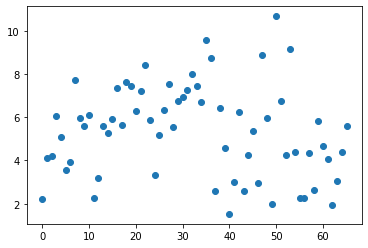

In [7]:
voc_len_arr = np.array(voc_lengths)/1000
plt.plot(voc_len_arr, 'o')
print('longest vocalization: ',max(voc_len_arr), "seconds")
print('shortest vococalization:', min(voc_len_arr), "seconds")
voc_length = 6
print('Petcentage of vocalizations less than ', voc_length, ' seconds long:', np.sum(voc_len_arr < voc_length)/len(voc_len_arr), '%')
voc_length = 8
print('Petcentage of vocalizations less than ', voc_length, ' seconds long:', np.sum(voc_len_arr < voc_length)/len(voc_len_arr), '%')

## Generate noise files

In [8]:
def get_white_noise(signal,SNR) :
    RMS_s = np.sqrt(np.mean(signal**2))
    RMS_n = np.sqrt(RMS_s**2/(pow(10,SNR/10)))
    STD_n = RMS_n
    noise = np.random.normal(0, STD_n, signal.shape[0])
    return noise

In [9]:
def get_noise_signal(signal_file, sr=sr):
    audio_chunk = AudioSegment.from_wav(signal_file)
    samples = audio_chunk.get_array_of_samples()
    audio_chunk_data = np.array(samples).astype(np.float32)/32768 # convert 24 bit wav file to 16 bit
    data = librosa.resample(audio_chunk_data, audio_chunk.frame_rate, sr, res_type='kaiser_best')
    final_len_seconds = 8
    len_to_fill = int(final_len_seconds * sr)
    data = (data, False, True)
    sound = data[0]
    len_filled = len(sound)
    len_filled_seconds = len_filled / sr 
    initial_sound = sound
    if (len(initial_sound) < len_to_fill):
        for n in range(0, int(final_len_seconds//len_filled_seconds)-1):
            initial_sound=np.concatenate((initial_sound,sound), axis=0)
        len_to_pad = len_to_fill-len(initial_sound)
        final_data = np.pad(initial_sound, [(0, len_to_pad)], mode='mean')
    else:
        rate=len(initial_sound)/len_to_fill
        final_data = librosa.effects.time_stretch(initial_sound, rate)
    return (final_data, data[1], data[2])

In [10]:
none=[]
for filename in os.listdir('../input/noise/'):
    if filename.endswith(".wav"):
        signal = get_noise_signal('../input/noise/'+filename)
        none.append(signal)
for x in range(2):
    for filename in os.listdir('../input/noise/'):
        if filename.endswith(".wav"):
            signal = get_noise_signal('../input/noise/'+filename)
            noise = get_white_noise(signal[0],SNR=6)
            none.append((noise, signal[1], signal[2]))
    for filename in os.listdir('../input/noise/'):
        if filename.endswith(".wav"):
            signal = get_noise_signal('../input/noise/'+filename)
            noise = get_white_noise(signal[0],SNR=6)
            none.append((signal[0]+noise, signal[1], signal[2]))

In [11]:
len(none)

15

## Split into test and train datasets

In [12]:
from sklearn.model_selection import train_test_split

In [13]:
train_test_ratio = 0.2

In [14]:
rumble_train, rumble_test = train_test_split(rumble, test_size = train_test_ratio, random_state=10)
none_train, none_test  = train_test_split(none, test_size = train_test_ratio, random_state=10)

In [15]:
print("Total number of files: ", len(rumble)+len(none))
print("Train files:")
print("Rumble: ", len(rumble_train))
print("None: ", len(none_train))
print()
print("Test files:")
print("Rumble: ", len(rumble_test))
print("None: ", len(none_test))

Total number of files:  81
Train files:
Rumble:  52
None:  12

Test files:
Rumble:  14
None:  3


## Process data

In [16]:
from sklearn.preprocessing import MinMaxScaler
import scipy.signal

In [17]:
def rand_stretch(sound, rate=np.random.uniform(low=0.5,high=1.5)):
    """
    Randomly squeeze or strech the sound array in the passed data and return the squeezed file
    Params - 
    sound: Array(soundData, bit1, bit2)
    rate: constaints for how much to stretch or sqeeze the file. Default: squeeze or strech so that the new file is 0.5 to 1.5 the speed of the original
    
    Returns - 
    Array(squeezed file, bit1, bit2)
    """
    stretched_sound = librosa.effects.time_stretch(sound, rate)
    return stretched_sound

def stretch_breaths_list(data_list, repeat, append_fraction=1):
    """
    Do rand_stretch for a list of arays to be passed to rand_stretch
    Params - 
    data_list: list of arrays to be passed to rand_stretch
    repeat: How many time to pass list to rand_stretch. Essetially, the number of times to mulitply the number of sound arrays by 2
    append_fraction: fraction of data_list to randomly sample data_list and pass the sampled list to rand_stretch. By default takes the whole data_list
    """
    streched_data_list = []
    streched_data_list.extend(data_list)
    for i in range(0, repeat):
        np.random.shuffle(data_list)
        count = int(len(data_list) * (1-append_fraction))
        data_list_cut = data_list[count:]
        stretched = []
        for data in data_list_cut:
            sound = data[0]
            stretched.append((rand_stretch(sound), data[1], data[2]))
        streched_data_list.extend(stretched)
    return streched_data_list

In [18]:
def resize(data, final_len_seconds, sample_rate=22000):
    """
    Resize the sound file passed to it to a particular size so that it can be trained. The model requires all the arrays to be trained to be the same size
    If the sound file is smaller than the requied lenght to be padded, copy it a whole number of times and pad the rest with zeros
    If the sound file is bigger than the required length, squeeze it till it is the right length
    Params - 
    data: Array(soundData, bit1, bit2)
    final_len_seconds: length in seconds the file needs to be resized to
    sample_rate: current sample rate of the file
    
    Returns - 
    Array(ResizedSoundData, bit1, bit2)
    
    """
    len_to_fill = int(final_len_seconds * sample_rate)
    sound = data[0]
    len_filled = len(sound)
    len_filled_seconds = len_filled / sample_rate 
    initial_sound = sound
    if (len(initial_sound) < len_to_fill):
        for n in range(0, int(final_len_seconds//len_filled_seconds)-1):
            initial_sound=np.concatenate((initial_sound,sound), axis=0)
        len_to_pad = len_to_fill-len(initial_sound)
        final_data = np.pad(initial_sound, [(0, len_to_pad)], mode='constant', constant_values=0)#Pad with zeros
    else:
        rate=len(initial_sound)/len_to_fill
        final_data = librosa.effects.time_stretch(initial_sound, rate)
    return (final_data, data[1], data[2])

In [19]:
window_length = 25/1000   # in seconds 
filters_no = 50

In [20]:
# Reference: http://practicalcryptography.com/miscellaneous/machine-learning/guide-mel-frequency-cepstral-coefficients-mfccs/
def hz2mel(hz):
    return 1125 * np.log(1 + hz / 700)

def mel2hz(mel):
    return 700 * (np.exp(mel/1125) - 1)

##### This is the formula to calculate mel filterbanks for a particular frequency:
##### Reference: http://practicalcryptography.com/miscellaneous/machine-learning/guide-mel-frequency-cepstral-coefficients-mfccs/
<img src="../code/formula_blackbg.png">

In [21]:
def get_mel_filterbanks(audio, sample_rate, filters_no, window_length=0.023233, window_func = 'hamming', fmin=None, fmax=None):
    """
    Create melspectrogram from the audio sample.
    References: https://github.com/jameslyons/python_speech_features ; https://haythamfayek.com/2016/04/21/speech-processing-for-machine-learning.html
                https://sci-hub.se/10.1109/ICASSP.2013.6639061
    Params - sound file, sample rate, number of filters needed, window lenth for sfft, window function for sfft, 

    Returns -
    Filterbanks as cube root values reshaped to constant float array

    """
    windows_no = int(window_length*sample_rate)   # no of windows to use for a 25 ms window length

    (f, t, Sxx) = scipy.signal.spectrogram(audio,fs = sample_rate, nfft= windows_no, nperseg=windows_no, window=window_func)    # Get frequency spectrogram signal

    if fmin is None:
        fmin = min(f)
    if fmax is None:
        fmax = max(f)

    freq_slice = np.where((f >= fmin) & (f <= fmax)) # Remove frequencies above fmax
    freq_bins = f[freq_slice]
    Sxx = Sxx[freq_slice,:][0]

    max_mel = hz2mel(max(freq_bins))
    min_mel = hz2mel(min(freq_bins))
    mel_bins = np.linspace(min_mel, max_mel, num = (filters_no+2))      # Creating the mel scale f() in the above equation
    mel_freq_bins = mel2hz(mel_bins)  

    all_fbanks = []
    for m in range(1, filters_no+1): 
        fbank = []
        for k in freq_bins:
            if(k < mel_freq_bins[m-1]):
                hm = 0
            elif(k < mel_freq_bins[m]):
                hm = (k - mel_freq_bins[m-1]) / (mel_freq_bins[m] - mel_freq_bins[m-1])
            elif(k < mel_freq_bins[m + 1]):
                hm = (mel_freq_bins[m+1] - k) / (mel_freq_bins[m + 1] - mel_freq_bins[m])
            else:
                hm = 0
            fbank.append(hm)
        all_fbanks.append(fbank)
    all_fbanks = np.array(all_fbanks).astype(np.float32)

    sound_mel_filterbanks = np.matmul(all_fbanks, Sxx)
    cbrt_mel_fbanks = np.cbrt(sound_mel_filterbanks  + float(10e-12))   # Cube root is taken here instead of log as it is much more robust
                                                        # Adding a very small number to prevent log 0
    scaler = MinMaxScaler()
    scaler.fit(cbrt_mel_fbanks)
    scaler.data_max_
    norm_cbrt_mel_fbanks=scaler.transform(cbrt_mel_fbanks)    # Normalize sound
    return np.reshape(norm_cbrt_mel_fbanks, (filters_no,Sxx.shape[1],1)).astype(np.float32)

In [22]:
def one_hot_encode(data):
    """
    One hot encode the data for training
    Params - 
    data: flags to one hot encode
    
    Returns - 
    one hot encoded label array
    """
    if (data[1] == True) & (data[2] == False):
        one_hot_label = np.array([1,0])
    elif (data[1] == False) & (data[2] == True):
        one_hot_label = np.array([0,1])
    return one_hot_label  

In [23]:
def resize_mel_and_onehot_list(data_list, final_len_seconds, sample_rate=22000):
    """
    Do resize, get_mel_filterbanks and one_hot_encode on a list of the arrays to be passes
    Params - 
    data_list: List of arrays to be passed
    final_len_seconds: Seconds to which all files in array have to be resized
    sample_rate: Sample rate of each array
    """
    final_list=[]
    for data in data_list:
        resized = resize(data, final_len_seconds, sample_rate)
        mel = get_mel_filterbanks(resized[0], sample_rate, 50)
        one_hot_label = one_hot_encode(data)
        final_list.append((mel, one_hot_label))
    return final_list

In [24]:
rumble_stretched_train = rumble_train   

In [25]:
none_stretched_train=stretch_breaths_list(none_train, 3)

In [26]:
print("Train files:")
print("rumble: ", len(rumble_stretched_train))
print("none: ", len(none_stretched_train))

Train files:
rumble:  52
none:  48


In [27]:
rumble_final_train = resize_mel_and_onehot_list(rumble_stretched_train,8)
none_final_train = resize_mel_and_onehot_list(none_stretched_train,8)

In [28]:
train_dict = {'rumble':rumble_final_train,'none':none_final_train}

In [29]:
rumble_stretched_test = rumble_test

In [30]:
none_stretched_test=stretch_breaths_list(none_test, 3)

In [31]:
print("Test files:")
print("rumble: ", len(rumble_stretched_test))
print("none: ", len(none_stretched_test))

Test files:
rumble:  14
none:  12


In [32]:
rumble_final_test = resize_mel_and_onehot_list(rumble_stretched_test,8)
none_final_test = resize_mel_and_onehot_list(none_stretched_test,8)

In [33]:
test_dict = {'rumble':rumble_final_test,'none':none_final_test}

(50, 392, 1)


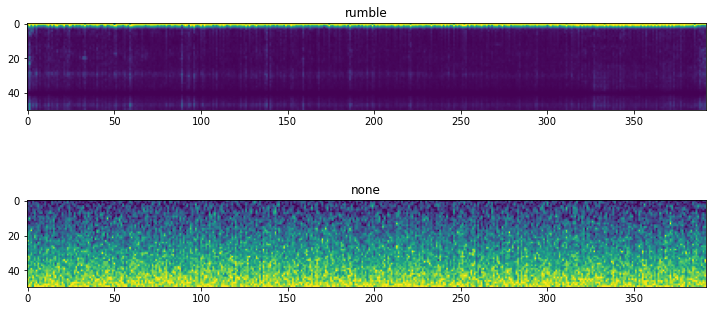

In [34]:
sample_height = train_dict['none'][0][0].shape[0]
sample_width = train_dict['none'][0][0].shape[1]
ind = 4
plt.figure(figsize = (10,10))
plt.subplot(4,1,1)
plt.imshow(train_dict['rumble'][ind][0].reshape(sample_height, sample_width))
plt.title('rumble')
plt.subplot(4,1,2)
plt.imshow(train_dict['none'][ind][0].reshape(sample_height, sample_width))
plt.title('none')
plt.tight_layout()
print(train_dict['none'][0][0].shape)

## Data Pipeline

In [35]:
import scipy.signal

"""
Data generator for both traning and validation. Wraps each sound array on its time axis using FFTroll before feeding to the model
Reference: https://stanford.edu/~shervine/blog/keras-how-to-generate-data-on-the-fly
"""
class data_generator():
    def __init__(self, sound_clips, strides):
        self.clips = sound_clips
        self.strides = strides
        self.lengths = [len(arr) for arr in sound_clips]
        print(int(min(np.divide(self.lengths, self.strides))) * 2)
    
    def n_available_samples(self):
        x=int(min(np.divide(self.lengths, self.strides))) * 2
        return x
    
    def generate_keras(self, batch_size):
        cursor = [0,0]
        while True:
            i = 0
            X,y = [],[]
            for c in range(batch_size):
                cat_length = self.lengths[i]
                cat_clips = self.clips[i]
                cat_stride = self.strides[i]
                cat_advance = np.random.randint(low= 1,high = cat_stride + 1)
                clip = cat_clips[(cursor[i] + cat_advance) % cat_length]
                cursor[i] = (cursor[i] + self.strides[i]) % cat_length #advance cursor
                s = (self.rollFFT(clip))
                X.append(s[0])
                y.append(s[1])
                i = (i + 1) % 2 # go to next class
            yield (np.reshape(X, (batch_size, sample_height, sample_width, 1)),
                   np.reshape(y,(batch_size,2)))

    #Transpose and wrap each array along the time axis
    def rollFFT(self, fft_info):
        fft = fft_info[0]
        n_col = fft.shape[1]
        pivot = np.random.randint(n_col)
        return ((np.roll(fft, pivot, axis = 1)), fft_info[1])

#Used for validation set
class feed_all():
    #sound_clips = [[none],[crackles],[wheezes],[both]]
    #strides: How far the sampling index for each category is advanced for each step
    def __init__(self, sound_clips, roll = True):
        merged = []
        for arr in sound_clips:
            merged.extend(arr)
        np.random.shuffle(merged)
        self.clips = merged
        self.nclips = len(merged)
        self.roll = roll
    
    def n_available_samples(self):
        return len(self.clips)
    
    def generate_keras(self, batch_size):
        i = 0
        while True:
            X,y = [],[]
            for b in range(batch_size):
                clip = self.clips[i]
                i = (i + 1) % self.nclips
                if(self.roll):
                    s = (self.rollFFT(clip))
                    X.append(s[0])
                    y.append(s[1])
                else:
                    X.append(clip[0])
                    y.append(clip[1])
                    
            yield (np.reshape(X, (batch_size,sample_height, sample_width,1)),
                   np.reshape(y,(batch_size, 2)))

    #Transpose and wrap each array along the time axis
    def rollFFT(self, fft_info):
        fft = fft_info[0]
        n_col = fft.shape[1]
        pivot = np.random.randint(n_col)
        return ((np.roll(fft, pivot, axis = 1)), fft_info[1])

In [36]:
batch_size = 16
epochs = 4

In [37]:
[rumble_test, none_test] =  [test_dict['rumble'], test_dict['none']]

#Data pipeline objects
train_gen = data_generator([train_dict['rumble'], train_dict['none']], [1,1])
test_gen = feed_all([rumble_test, none_test])

96


In [38]:
none_train[0][0].shape

(176000,)

In [39]:
#Keras implementation
from tensorflow.keras import Sequential
from tensorflow.keras import optimizers
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Conv2D, Dense, Activation, Dropout, MaxPool2D, Flatten, LeakyReLU
import tensorflow as tf
K.clear_session()

model = Sequential()
model.add(Conv2D(128, [7,11], strides = [2,2], padding = 'SAME', input_shape = (sample_height, sample_width, 1)))
model.add(LeakyReLU(alpha = 0.1))
model.add(MaxPool2D(padding = 'SAME'))

model.add(Conv2D(256, [5,5], padding = 'SAME'))
model.add(LeakyReLU(alpha = 0.1))
model.add(MaxPool2D(padding = 'SAME'))

model.add(Conv2D(256, [1,1], padding = 'SAME'))
model.add(Conv2D(256, [3,3], padding = 'SAME'))
model.add(LeakyReLU(alpha = 0.1))
model.add(MaxPool2D(padding = 'SAME'))

model.add(Conv2D(512, [1,1], padding = 'SAME'))
model.add(Conv2D(512, [3,3], padding = 'SAME',activation = 'relu'))
model.add(Conv2D(512, [1,1], padding = 'SAME'))
model.add(Conv2D(512, [3,3], padding = 'SAME', activation = 'relu'))
model.add(MaxPool2D(padding = 'SAME'))
model.add(Flatten())

model.add(Dense(4096, activation = 'relu'))
model.add(Dropout(0.5))

model.add(Dense(512, activation = 'relu'))
model.add(Dense(2, activation = 'softmax'))

initial_learning_rate = 0.0001
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate = initial_learning_rate,
    decay_steps=5,
    decay_rate=0.96,
    staircase=True
)

opt = optimizers.Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.00, amsgrad=False)

#opt = optimizers.Adam(learning_rate=lr_schedule, beta_1=0.9, beta_2=0.999, epsilon=None, amsgrad=False)

model.compile(optimizer =  opt , loss = 'categorical_crossentropy', metrics = ['acc'])

2022-01-29 02:43:56.960140: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-01-29 02:43:56.960173: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2022-01-29 02:44:00.995486: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-01-29 02:44:00.996025: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-01-29 02:44:00.996400: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublas.so.11'; dlerror: libcublas.s

In [40]:
stats = model.fit_generator(generator = train_gen.generate_keras(batch_size), 
                            steps_per_epoch = train_gen.n_available_samples() // batch_size,
                            validation_data = test_gen.generate_keras(batch_size),
                            validation_steps = test_gen.n_available_samples() // batch_size, 
                            epochs = epochs)

/tmp/ipykernel_1127495/3077336977.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  stats = model.fit_generator(generator = train_gen.generate_keras(batch_size),


Epoch 1/4


2022-01-29 02:44:02.532280: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 218103808 exceeds 10% of free system memory.
2022-01-29 02:44:02.653369: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 218103808 exceeds 10% of free system memory.


6/6 [==============================] - 28s 4s/step - loss: 0.5786 - acc: 0.5729 - val_loss: 0.3555 - val_acc: 1.0000
Epoch 2/4
6/6 [==============================] - 29s 5s/step - loss: 0.3386 - acc: 0.8854 - val_loss: 0.0361 - val_acc: 1.0000
Epoch 3/4
6/6 [==============================] - 23s 4s/step - loss: 0.3052 - acc: 0.8854 - val_loss: 0.4728 - val_acc: 0.8750
Epoch 4/4
6/6 [==============================] - 25s 4s/step - loss: 0.2641 - acc: 0.8854 - val_loss: 0.0412 - val_acc: 1.0000


Text(0.5, 1.0, 'Loss')

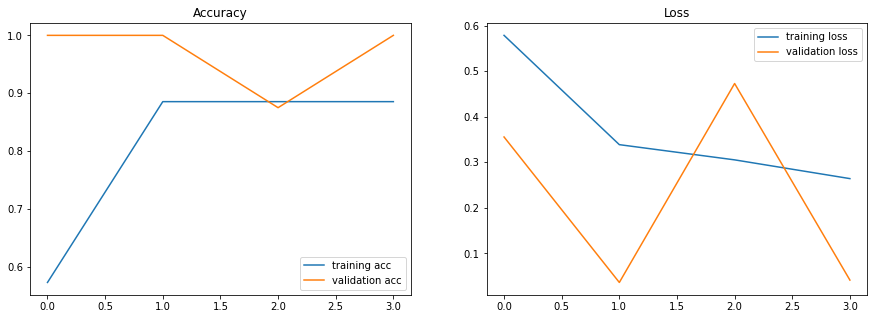

In [47]:
plt.figure(figsize = (15,5))
plt.subplot(1,2,1)
plt.title('Accuracy')
plt.plot(stats.history['acc'], label = 'training acc')
plt.plot(stats.history['val_acc'], label = 'validation acc')
plt.legend()
plt.subplot(1,2,2)
plt.plot(stats.history['loss'], label = 'training loss')
plt.plot(stats.history['val_loss'], label = 'validation loss')
plt.legend()
plt.title('Loss')

In [56]:
test_set = test_gen.generate_keras(test_gen.n_available_samples()).__next__()
predictions = model.predict(test_set[0])
predictions = np.argmax(predictions, axis = 1)
labels = np.argmax(test_set[1], axis = 1)
predictions

array([1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 1, 1, 1])

In [58]:
from sklearn.metrics import classification_report, confusion_matrix

print(classification_report(labels, predictions, target_names = ['rubmle','none']))
cm = confusion_matrix(labels, predictions)
print(cm)

              precision    recall  f1-score   support

      rubmle       1.00      1.00      1.00        14
        none       1.00      1.00      1.00        12

    accuracy                           1.00        26
   macro avg       1.00      1.00      1.00        26
weighted avg       1.00      1.00      1.00        26

[[14  0]
 [ 0 12]]


In [50]:
labels = ['rumble','none']
cm_df = pd.DataFrame(cm, columns=labels, index=labels)

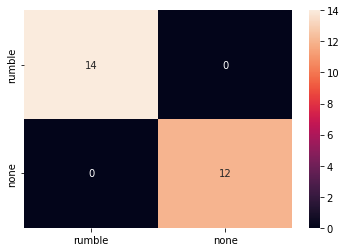

In [54]:
import seaborn as sns
ax = sns.heatmap(cm_df, annot=True, fmt='g')

In [52]:
model.save('./AL_model.h5')